# Task3 特征工程

此部分为零基础入门金融风控的 Task3 特征工程部分，带你来了解各种特征工程以及分析方法，欢迎大家后续多多交流。

赛题：零基础入门数据挖掘 - 零基础入门金融风控之贷款违约


项目地址：https://github.com/datawhalechina/team-learning-data-mining/tree/master/FinancialRiskControl

比赛地址：https://tianchi.aliyun.com/competition/entrance/531830/introduction

## 3.1 学习目标

- 学习特征预处理、缺失值、异常值处理、数据分桶等特征处理方法
- 学习特征交互、编码、选择的相应方法
- 完成相应学习打卡任务，两个选做的作业不做强制性要求，供学有余力同学自己探索

## 3.2 内容介绍

- 数据预处理：
  - 缺失值的填充
  - 时间格式处理
  - 对象类型特征转换到数值
- 异常值处理：
  - 基于3segama原则
  - 基于箱型图
- 数据分箱
  - 固定宽度分箱
  - 分位数分箱
    - 离散数值型数据分箱
    - 连续数值型数据分箱
  - 卡方分箱（选做作业）
- 特征交互
  - 特征和特征之间组合
  - 特征和特征之间衍生
  - 其他特征衍生的尝试（选做作业）
- 特征编码
  - one-hot编码
  - label-encode编码
- 特征选择
    - 1 Filter
    - 2 Wrapper （RFE）
    - 3 Embedded

## 3.3 代码示例

### 3.3.1 导入包并读取数据

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

In [242]:
data_train =pd.read_csv('../train.csv')
data_test_a = pd.read_csv('../testA.csv')

### 3.3.2特征预处理

- 数据EDA部分我们已经对数据的大概和某些特征分布有了了解，数据预处理部分一般我们要处理一些EDA阶段分析出来的问题，这里介绍了数据缺失值的填充，时间格式特征的转化处理，某些对象类别特征的处理。

首先我们查找出数据中的对象特征和数值特征

In [243]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

在比赛中数据预处理是必不可少的一部分，对于缺失值的填充往往会影响比赛的结果，在比赛中不妨尝试多种填充然后比较结果选择结果最优的一种；
比赛数据相比真实场景的数据相对要“干净”一些，但是还是会有一定的“脏”数据存在，清洗一些异常值往往会获得意想不到的效果。

#### 缺失值填充

- 把所有缺失值替换为指定的值0

    data_train = data_train.fillna(0)


- 向用缺失值上面的值替换缺失值

    data_train = data_train.fillna(axis=0,method='ffill')


- 纵向用缺失值下面的值替换缺失值,且设置最多只填充两个连续的缺失值

    data_train = data_train.fillna(axis=0,method='bfill',limit=2)

In [246]:
#查看缺失值情况
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                

In [249]:
#按照平均数填充数值型特征
data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
#按照众数填充类别型特征
data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

In [248]:
data_train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n2.1                

In [233]:
#查看类别特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

- category_fea：对象型类别特征需要进行预处理，其中['issueDate']为时间格式特征。

#### 时间格式处理

In [234]:
#转化成时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [235]:
data_train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

#### 对象类型特征转换到数值

In [236]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [237]:
data['employmentLength'].value_counts(dropna=False).sort_index()

0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: employmentLength, dtype: int64

- 对earliesCreditLine进行预处理

In [238]:
data_train['earliesCreditLine'].sample(5)

519915    Sep-2002
564368    Dec-1996
768209    May-2004
453092    Nov-1995
763866    Sep-2000
Name: earliesCreditLine, dtype: object

In [239]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

#### 类别特征处理


In [218]:
# 部分类别特征
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

grade 类型数： 7
subGrade 类型数： 35
employmentTitle 类型数： 79282
homeOwnership 类型数： 6
verificationStatus 类型数： 3
purpose 类型数： 14
postCode 类型数： 889
regionCode 类型数： 51
applicationType 类型数： 2
initialListStatus 类型数： 2
title 类型数： 12058
policyCode 类型数： 1


像等级这种类别特征，是有优先级的可以labelencode或者自映射

In [219]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [220]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
for data in [data_train, data_test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

### 3.3.3  异常值处理
- 当你发现异常值后，一定要先分清是什么原因导致的异常值，然后再考虑如何处理。首先，如果这一异常值并不代表一种规律性的，而是极其偶然的现象，或者说你并不想研究这种偶然的现象，这时可以将其删除。其次，如果异常值存在且代表了一种真实存在的现象，那就不能随便删除。在现有的欺诈场景中很多时候欺诈数据本身相对于正常数据勒说就是异常的，我们要把这些异常点纳入，重新拟合模型，研究其规律。能用监督的用监督模型，不能用的还可以考虑用异常检测的算法来做。
- 注意test的数据不能删。

#### 检测异常的方法一：均方差

在统计学中，如果一个数据分布近似正态，那么大约 68% 的数据值会在均值的一个标准差范围内，大约 95% 会在两个标准差范围内，大约 99.7% 会在三个标准差范围内。

In [240]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

- 得到特征的异常值后可以进一步分析变量异常值和目标变量的关系

In [173]:
data_train = data_train.copy()
for fea in numerical_fea:
    data_train = find_outliers_by_3segama(data_train,fea)
    print(data_train[fea+'_outliers'].value_counts())
    print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

- 例如可以看到异常值在两个变量上的分布几乎复合整体的分布，如果异常值都属于为1的用户数据里面代表什么呢？

In [175]:
#删除异常值
for fea in numerical_fea:
    data_train = data_train[data_train[fea+'_outliers']=='正常值']
    data_train = data_train.reset_index(drop=True) 

#### 检测异常的方法二：箱型图

- 总结一句话：四分位数会将数据分为三个点和四个区间，IQR = Q3 -Q1，下触须=Q1 − 1.5x IQR，上触须=Q3 + 1.5x IQR；

### 3.3.4 数据分桶

- 特征分箱的目的：
  - 从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量和因变量的相关度。从而使模型更加稳定。
- 数据分桶的对象：
  - 将连续变量离散化
  - 将多状态的离散变量合并成少状态
- 分箱的原因：
  - 数据的特征内的值跨度可能比较大，对有监督和无监督中如k-均值聚类它使用欧氏距离作为相似度函数来测量数据点之间的相似度。都会造成大吃小的影响，其中一种解决方法是对计数值进行区间量化即数据分桶也叫做数据分箱，然后使用量化后的结果。
- 分箱的优点：
  - 处理缺失值：当数据源可能存在缺失值，此时可以把null单独作为一个分箱。
  - 处理异常值：当数据中存在离群点时，可以把其通过分箱离散化处理，从而提高变量的鲁棒性（抗干扰能力）。例如，age若出现200这种异常值，可分入“age > 60”这个分箱里，排除影响。
  - 业务解释性：我们习惯于线性判断变量的作用，当x越来越大，y就越来越大。但实际x与y之间经常存在着非线性关系，此时可经过WOE变换。

- 特别要注意一下分箱的基本原则：
  - （1）最小分箱占比不低于5%
  - （2）箱内不能全部是好客户
  - （3）连续箱单调

1. 固定宽度分箱 

当数值横跨多个数量级时，最好按照 10 的幂（或任何常数的幂）来进行分组：0~9、10~99、100~999、1000~9999，等等。固定宽度分箱非常容易计算，但如果计数值中有比较大的缺口，就会产生很多没有任何数据的空箱子。

In [37]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)

In [38]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

2. 分位数分箱

In [43]:
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

3. 卡方分箱及其他分箱方法的尝试
 - 这一部分属于进阶部分，学有余力的同学可以自行搜索尝试。

### 3.3.5 特征交互
- 交互特征的构造非常简单，使用起来却代价不菲。如果线性模型中包含有交互特征对，那它的训练时间和评分时间就会从 O(n) 增加到 O(n2)，其中 n 是单一特征的数量。

In [221]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [222]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n2.1','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

#### 这里给出一些特征交互的思路，但特征和特征间的交互衍生出新的特征还远远不止于此，抛砖引玉，希望大家多多探索。请学习者尝试其他的特征交互方法

### 3.3.6 特征编码


#### labelEncode 直接放入树模型中

In [224]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:08<00:00,  2.04s/it]

Label Encoding 完成


#### 逻辑回归等模型要单独增加的特征工程
- 对特征做归一化，去除相关性高的特征
- 归一化目的是让训练过程更好更快的收敛，避免特征大吃小的问题
- 去除相关性是增加模型的可解释性，加快预测过程。

In [ ]:
# 举例归一化过程
#伪代码
for fea in [要归一化的特征列表]：
    data[fea] = ((data[fea] - np.min(data[fea])) / (np.max(data[fea]) - np.min(data[fea])))

### 3.3.7 特征选择
- 特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。特征选择不是为了减少训练时间（实际上，一些技术会增加总体训练时间），而是为了减少模型评分时间。

特征选择的方法：

- 1 Filter
  - 方差选择法
  - 相关系数法（pearson 相关系数）
  - 卡方检验
  - 互信息法
- 2 Wrapper （RFE）
  - 递归特征消除法
- 3 Embedded
  - 基于惩罚项的特征选择法
  - 基于树模型的特征选择

#### Filter
- 基于特征间的关系进行筛选

方差选择法
- 方差选择法中，先要计算各个特征的方差，然后根据设定的阈值，选择方差大于阈值的特征

In [ ]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,target_train)

相关系数法
- Pearson 相关系数
  皮尔森相关系数是一种最简单的，可以帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性。
  结果的取值区间为 [-1，1] ， -1 表示完全的负相关， +1表示完全的正相关，0 表示没有线性相关。

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)

卡方检验
- 经典的卡方检验是用于检验自变量对因变量的相关性。 假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。 其统计量如下： χ2=∑(A−T)2T，其中A为实际值，T为理论值
- (注：卡方只能运用在正定矩阵上，否则会报错Input X must be non-negative)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数

SelectKBest(chi2, k=5).fit_transform(train,target_train)

互信息法
- 经典的互信息也是评价自变量对因变量的相关性的。 在feature_selection库的SelectKBest类结合最大信息系数法可以用于选择特征，相关代码如下：

In [ ]:
from sklearn.feature_selection import SelectKBest
from minepy import MINE
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，
#返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
#参数k为选择的特征个数
SelectKBest(lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2).fit_transform(train,target_train)

#### Wrapper （Recursive feature elimination，RFE）
- 递归特征消除法 递归消除特征法使用一个基模型来进行多轮训练，每轮训练后，消除若干权值系数的特征，再基于新的特征集进行下一轮训练。 在feature_selection库的RFE类可以用于选择特征，相关代码如下（以逻辑回归为例）：

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#递归特征消除法，返回特征选择后的数据
#参数estimator为基模型
#参数n_features_to_select为选择的特征个数

RFE(estimator=LogisticRegression(), n_features_to_select=2).fit_transform(train,target_train)

#### Embedded
- 基于惩罚项的特征选择法 使用带惩罚项的基模型，除了筛选出特征外，同时也进行了降维。 在feature_selection库的SelectFromModel类结合逻辑回归模型可以用于选择特征，相关代码如下：


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1惩罚项的逻辑回归作为基模型的特征选择

SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(train,target_train)

- 基于树模型的特征选择 树模型中GBDT也可用来作为基模型进行特征选择。 在feature_selection库的SelectFromModel类结合GBDT模型可以用于选择特征，相关代码如下：


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(train,target_train)

#### 本数据集中我们删除非入模特征后，并对缺失值填充，然后用计算协方差的方式看一下特征间相关性，然后进行模型训练

In [ ]:
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [ ]:
"纵向用缺失值上面的值替换缺失值"
data_train = data_train.fillna(axis=0,method='ffill')

In [226]:
x_train = data_train.drop(['isDefault','id'], axis=1)
#计算协方差
data_corr = x_train.corrwith(data_train.isDefault) #计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

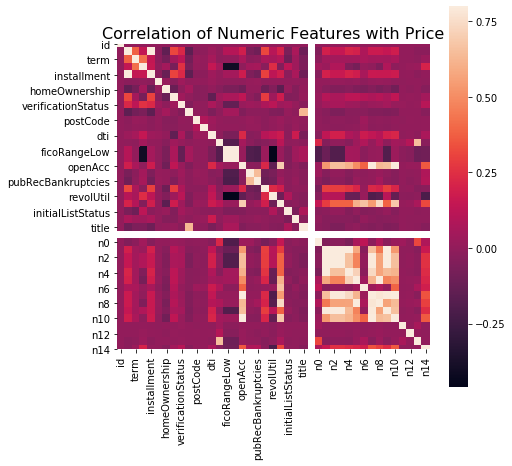

In [227]:
# 当然也可以直接看图
data_numeric = data_train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [184]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

In [185]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [186]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [187]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749225	valid_1's auc: 0.729679
[400]	training's auc: 0.765075	valid_1's auc: 0.730496
[600]	training's auc: 0.778745	valid_1's auc: 0.730435
Early stopping, best iteration is:
[455]	training's auc: 0.769202	valid_1's auc: 0.730686
[0.7306859913754798]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749221	valid_1's auc: 0.731315
[400]	training's auc: 0.765117	valid_1's auc: 0.731658
[600]	training's auc: 0.778542	valid_1's auc: 0.731333
Early stopping, best iteration is:
[407]	training's auc: 0.765671	valid_1's auc: 0.73173
[0.7306859913754798, 0.7317304414673989]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training'

In [188]:
testA_result = pd.read_csv('../testA_result.csv')

In [189]:
roc_auc_score(testA_result['isDefault'].values, lgb_test)

0.7290917729487896

## 3.4 总结

特征工程是机器学习，甚至是深度学习中最为重要的一部分，在实际应用中往往也是所花费时间最多的一步。各种算法书中对特征工程部分的讲解往往少得可怜，因为特征工程和具体的数据结合的太紧密，很难系统地覆盖所有场景。本章主要是通过一些常用的方法来做介绍，例如缺失值异常值的处理方法详细对任何数据集来说都是适用的。但对于分箱等操作本章给出了具体的几种思路，需要读者自己探索。在特征工程中比赛和具体的应用还是有所不同的，在实际的金融风控评分卡制作过程中，由于强调特征的可解释性，特征分箱尤其重要。学有余力同学可以自行多尝试，希望大家在本节学习中有所收获。

END.

【 言溪：Datawhale成员，金融风控爱好者。知乎地址：https://www.zhihu.com/people/exuding】

关于Datawhale： Datawhale是一个专注于数据科学与AI领域的开源组织，汇集了众多领域院校和知名企业的优秀学习者，聚合了一群有开源精神和探索精神的团队成员。Datawhale 以“for the learner，和学习者一起成长”为愿景，鼓励真实地展现自我、开放包容、互信互助、敢于试错和勇于担当。同时 Datawhale 用开源的理念去探索开源内容、开源学习和开源方案，赋能人才培养，助力人才成长，建立起人与人，人与知识，人与企业和人与未来的联结。 本次数据挖掘路径学习，专题知识将在天池分享，详情可关注Datawhale：

![logo.png](https://img-blog.csdnimg.cn/2020091301022698.png#pic_center)